In [1]:

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

import sys

sys.path.append('../')

# from algorithms.sequence_models.old_decision_transformer.decision_transformer.decision_transformer import DecisionTransformer
from algorithms.sequence_models.decision_transformer.decision_transformer import DecisionTransformer
from algorithms.sequence_models.evaluate import evaluate_on_env
from data.random_walk_dataset import RandomWalkDataset
from envs.random_walk import RandomWalkEnv
from data.trajectory import LimitedContextWrapper
from algorithms.sequence_models.config import TrainConfig
from algorithms.sequence_models.decision_transformer.trainer import TrainerDT

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

pygame 2.5.2 (SDL 2.28.2, Python 3.10.14)
Hello from the pygame community. https://www.pygame.org/contribute.html


2024-05-10 13:02:23.643263: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-10 13:02:24.026359: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-10 13:02:24.800782: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


device(type='cuda')

In [2]:
class CustomCallback:
	def __init__(self, env, model, optimizer, logger, device, traj_dataset, config, rtgs=[]):
		self.env = env
		self.model = model
		self.optimizer = optimizer
		self.logger = logger
		self.device = device
		self.traj_dataset = traj_dataset
		self.config = config
		self.rtgs = rtgs
		self.eval_results = []
		
	def callback(self, df, **kwargs):
		results = evaluate_on_env(
			model=self.model, traj_dataset=self.traj_dataset,
			device=self.device, context_len=self.config.context_len,
			env=self.env, rtg_target=self.config.rtg_main,
			num_eval_ep=self.config.num_eval_ep,
			max_test_ep_len=self.config.max_eval_ep_len)
		self.logger.log(
				   model=self.model,
				   loss=df['train/loss'].sum(),
				   eval_avg_reward=results['eval/avg_reward'],
				   eval_avg_ep_len=results['eval/avg_ep_len'],
				   grad_norm=max(torch.norm(param.grad) for param in self.model.parameters() if param.grad is not None),
				   lr=self.optimizer.param_groups[0]['lr'],
				   important={"grad_norm", "lr"})
		res = {}
		for rtg in self.rtgs:
			res[rtg] = evaluate_on_env(
				model=self.model,
				traj_dataset=self.traj_dataset,
				device=self.device,
				context_len=self.config.context_len,
				env=self.env,
				rtg_target=rtg,
				num_eval_ep=self.config.num_eval_ep
			)
		self.eval_results.append(res)
	
	def plot_eval_results(self):
		plt.figure()
		for rtg in self.rtgs:
			plt.plot([res[rtg]['eval/avg_reward'] for res in self.eval_results])
		plt.xlabel('iteration')
		plt.ylabel('avg_reward')
		plt.legend([f'r={rtg:.2f}' for rtg in self.rtgs])

		plt.figure()
		
		for rtg in self.rtgs:
			n = len(self.eval_results)
			plt.plot(range(n//2, n), [res[rtg]['eval/avg_reward'] for res in self.eval_results[n//2:]])
			
		plt.xlabel('iteration')
		plt.ylabel('avg_reward')
		plt.legend([f'r={rtg:.2f}' for rtg in self.rtgs])

/snap/pycharm-professional/387/plugins/python/helpers/pydev/pydevd_plugins/__init__.py:2: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('pydevd_plugins')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  __import__('pkg_resources').declare_namespace(__name__)
/snap/pycharm-professional/387/plugins/python/helpers/pydev/pydevd_plugins/extensions/__init__.py:2: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('pydevd_plugins.extensions')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  __import__('pkg_resources').declare_namespace(__name__)
/snap/pycharm-professional/387/plugins/python/helpers/pydev/pydevd_plugins/e

In [3]:
env = RandomWalkEnv(num_nodes=10, weight_max=10, reach_the_goal_reward=10, max_episode_length=20)
config = TrainConfig(max_eval_ep_len=20, context_len=25, rtg_range_check=(-10, 10), rtg_main=5)
traj_dataset = RandomWalkDataset(env, n_trajectories=500, reward_scale=20)

collecting trajectories:   0%|          | 0/500 [00:00<?, ?it/s]

Dataset Info:
episode_max_length: 20
reward_scale: 20
return min=-127, max=9 mean=-26.214132762312634
state_mean: [0.22341185 0.10516298 0.09897692 0.09302879 0.09374256 0.08612896
 0.1044492  0.09731144 0.09778729 0.        ]
state_std: [0.41653211 0.30676331 0.29863103 0.29047278 0.29147023 0.28055438
 0.30584239 0.29638139 0.29702683 0.        ]
gamma: 1


collecting trajectories:   0%|          | 0/500 [00:00<?, ?it/s]

Dataset Info:
episode_max_length: 20
reward_scale: 20
return min=-136, max=9 mean=-32.749045158391375
state_mean: [0.20669512 0.10132554 0.09975286 0.09773085 0.09256347 0.1002022
 0.0959335  0.10671759 0.09907886 0.        ]
state_std: [0.40493487 0.30175931 0.2996702  0.29695038 0.28981973 0.30026941
 0.29450002 0.30875386 0.29876787 0.        ]
gamma: 1
number of parameters 1125141


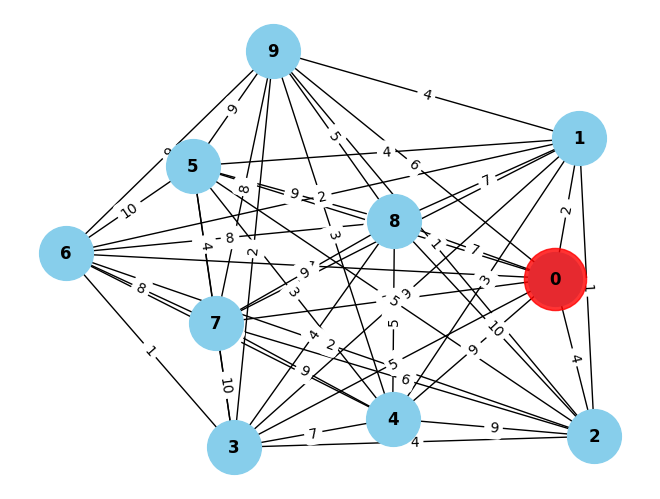

In [3]:
model = DecisionTransformer(
			state_dim=traj_dataset.state_dim(),
			act_dim=traj_dataset.action_dim(),
			n_blocks=config.n_blocks,
			h_dim=config.embed_dim,
			context_len=config.context_len,
			n_heads=config.n_heads,
			drop_p=config.dropout_p,
).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=config.lr, weight_decay=config.wt_decay)

scheduler = torch.optim.lr_scheduler.LambdaLR(
	optimizer,
	lambda steps: min((steps+1)/config.warmup_steps, 1)
)

loss_fn = nn.MSELoss(reduction='mean')

trainer = TrainerDT(name='random-walk-another', model=model,
					optimizer=optimizer, loss_fn=loss_fn,
					dataset=LimitedContextWrapper(traj_dataset, context_len=config.context_len),
					device=device, config=config, scheduler=scheduler)

callback = CustomCallback(env=env, model=model,
						  optimizer=optimizer, logger=trainer.logger, device=device, traj_dataset=traj_dataset, config=config,
						  rtgs=np.linspace(config.rtg_range_check[0], config.rtg_range_check[1], 5))

trainer.register_callback(callback.callback)

print("number of parameters", sum(np.prod(param.shape) for param in model.parameters()))

In [5]:
report = trainer.train()

  0%|          | 0/200 [00:00<?, ?it/s]

achieved average reward:  -18.0
saving max score model at: /home/shayan/projects/RL-credit-assignment-experiment/logs/dt_runs/dt_random-walk-another_model_24-05-09-20-50-55_best.pt
saving current model at: /home/shayan/projects/RL-credit-assignment-experiment/logs/dt_runs/dt_random-walk-another_model_24-05-09-20-50-55.pt
time elapsed: 0:00:15
num of updates: 100
loss: 28.14915
eval avg reward: -18.00000
best score: -inf
eval_avg_ep_len 5.00000
grad_norm 0.18951
lr 0.00001
achieved average reward:  4.0
saving max score model at: /home/shayan/projects/RL-credit-assignment-experiment/logs/dt_runs/dt_random-walk-another_model_24-05-09-20-50-55_best.pt
saving current model at: /home/shayan/projects/RL-credit-assignment-experiment/logs/dt_runs/dt_random-walk-another_model_24-05-09-20-50-55.pt
time elapsed: 0:00:20
num of updates: 200
loss: 14.82598
eval avg reward: 4.00000
best score: -18.00000
eval_avg_ep_len 1.00000
grad_norm 0.11189
lr 0.00002
achieved average reward:  4.0
saving max scor

KeyboardInterrupt: 

In [6]:
model

DecisionTransformer(
  (transformer): Sequential(
    (0): Block(
      (attention): MaskedCausalAttention(
        (q_net): Linear(in_features=128, out_features=128, bias=True)
        (k_net): Linear(in_features=128, out_features=128, bias=True)
        (v_net): Linear(in_features=128, out_features=128, bias=True)
        (proj_net): Linear(in_features=128, out_features=128, bias=True)
        (att_drop): Dropout(p=0.1, inplace=False)
        (proj_drop): Dropout(p=0.1, inplace=False)
      )
      (mlp): Sequential(
        (0): Linear(in_features=128, out_features=512, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=512, out_features=128, bias=True)
        (3): Dropout(p=0.1, inplace=False)
      )
      (ln1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (ln2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (1): Block(
      (attention): MaskedCausalAttention(
        (q_net): Linear(in_features=128, out_features=12

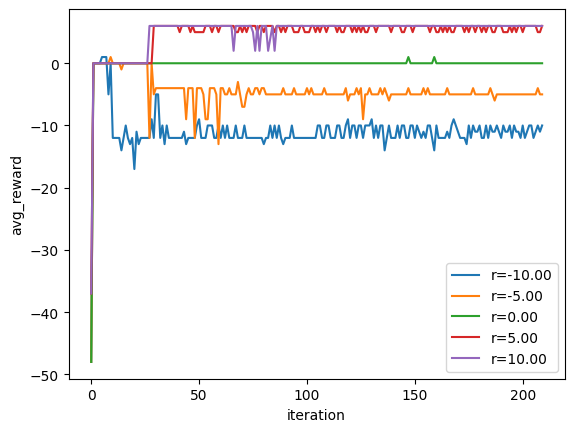

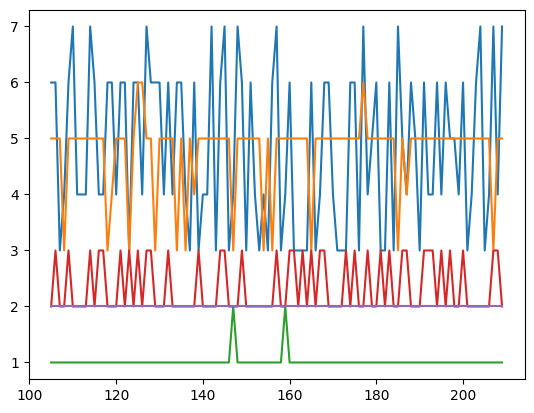

In [28]:
callback.plot_eval_results()

<Axes: >

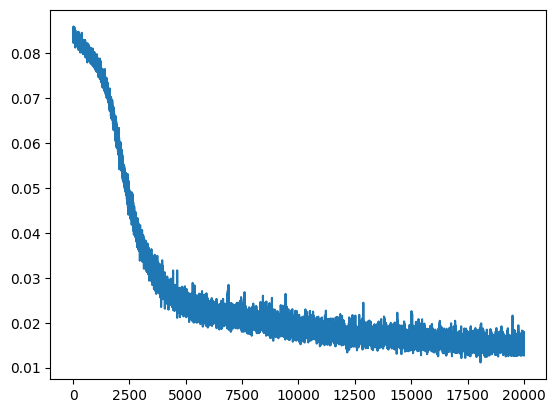

In [48]:
report.sort_values(by=['train/iteration', 'train/update_idx']).reset_index()['train/loss'].plot()

### Compare with S4

In [13]:
from s4.dts4 import DecisionS4 # todo later move to algorithms folder

experiment_name = 'random-walk-simple-s4'

model_s4 = DecisionS4(
    state_dim=traj_dataset.state_dim(),
    act_dim=traj_dataset.action_dim(),
    h_dim=config.embed_dim,
    context_len=config.context_len,
    drop_p=config.dropout_p,
).to(device)

optimizer = torch.optim.AdamW(model_s4.parameters(), lr=config.lr, weight_decay=config.wt_decay)

scheduler = torch.optim.lr_scheduler.LambdaLR(
	optimizer,
	lambda steps: min((steps+1)/config.warmup_steps, 1)
)

loss_fn = nn.MSELoss(reduction='mean')

trainer = TrainerDT(name=experiment_name, model=model_s4,
					optimizer=optimizer, loss_fn=loss_fn,
					dataset=LimitedContextWrapper(traj_dataset, context_len=config.context_len),
					device=device, config=config, scheduler=scheduler)

callback = CustomCallback(env=env, model=model_s4,
						  optimizer=optimizer, logger=trainer.logger, device=device, traj_dataset=traj_dataset, config=config,
						  rtgs=np.linspace(config.rtg_range_check[0], config.rtg_range_check[1], 5))

trainer.register_callback(callback.callback)

print("number of parameters", sum(np.prod(param.shape) for param in model_s4.parameters()))

number of parameters 596373


In [14]:
report = trainer.train()

  0%|          | 0/200 [00:00<?, ?it/s]

achieved average reward:  -32.0
saving max score model at: /home/shayan/projects/RL-credit-assignment-experiment/logs/dt_runs/dt_random-walk-simple-s4_model_24-05-10-13-12-31_best.pt
time elapsed: 0:00:01
num of updates: 100
loss: 11.98128
eval avg reward: -32.00000
best score: -inf
eval_avg_ep_len 7.00000
grad_norm 0.10803
lr 0.00001
achieved average reward:  -32.0
saving max score model at: /home/shayan/projects/RL-credit-assignment-experiment/logs/dt_runs/dt_random-walk-simple-s4_model_24-05-10-13-12-31_best.pt
time elapsed: 0:00:02
num of updates: 200
loss: 11.02888
eval avg reward: -32.00000
best score: -32.00000
eval_avg_ep_len 7.00000
grad_norm 0.06640
lr 0.00002
achieved average reward:  -19.0
saving max score model at: /home/shayan/projects/RL-credit-assignment-experiment/logs/dt_runs/dt_random-walk-simple-s4_model_24-05-10-13-12-31_best.pt
time elapsed: 0:00:03
num of updates: 300
loss: 10.08359
eval avg reward: -19.00000
best score: -32.00000
eval_avg_ep_len 5.00000
grad_nor

<Axes: >

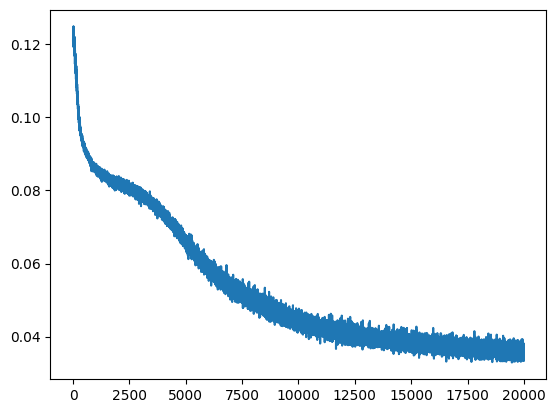

In [21]:
# plot losses

report.sort_values(by=['train/iteration', 'train/update_idx']).reset_index()['train/loss'].plot()

In [23]:
report['train/loss']

0     0.121003
1     0.122556
2     0.122416
3     0.123274
4     0.120859
        ...   
95    0.034880
96    0.035948
97    0.036265
98    0.036606
99    0.033459
Name: train/loss, Length: 20000, dtype: float64

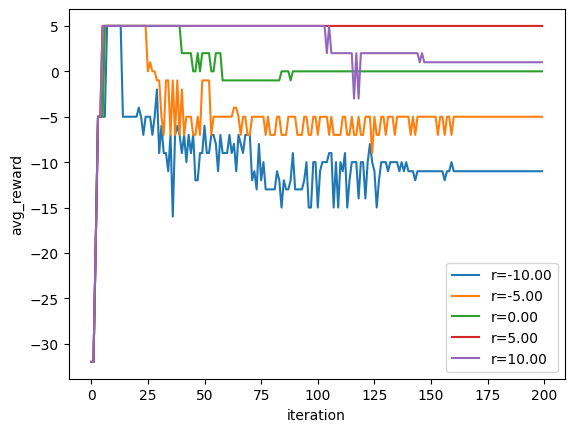

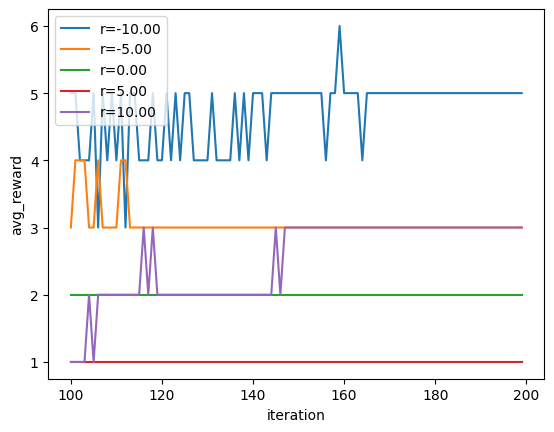

In [16]:
# how was the model learning while training?
callback.plot_eval_results()

  0%|          | 0/30 [00:00<?, ?it/s]

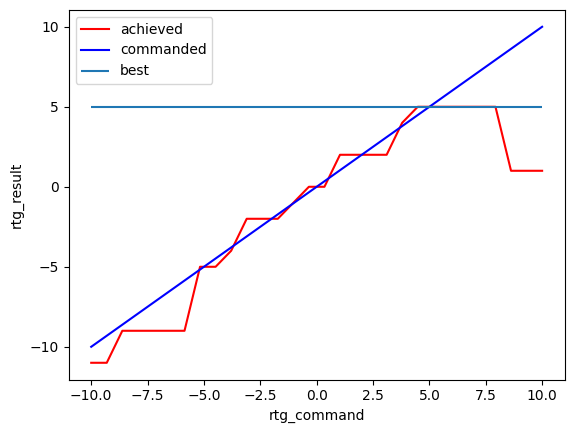

In [20]:
# main plot. command vs return

from tqdm.notebook import tqdm

rtg_command = np.linspace(config.rtg_range_check[0], config.rtg_range_check[1], 30)

rtg_result = []

for rtg in tqdm(rtg_command):
	res = evaluate_on_env(
		model=model_s4,
		traj_dataset=traj_dataset,
		device=device,
		context_len=config.context_len,
		env=env,
		rtg_target=rtg,
		num_eval_ep=config.num_eval_ep
	)
	rtg_result.append(res['eval/avg_reward'])

plt.plot(rtg_command, rtg_result, 'r')
plt.plot(rtg_command, rtg_command, 'b')
plt.xlabel("rtg_command")
plt.ylabel("rtg_result")


########################## specific to RandomWalk
import networkx as nx

shortest_path = nx.shortest_path(env.G, env.starting_vertex, env.ending_vertex, weight='weight')
best_score = env.reach_the_goal_reward - sum(env.G[a][b]['weight'] for a, b in zip(shortest_path[:-1], shortest_path[1:]))

plt.hlines(best_score, config.rtg_range_check[0], config.rtg_range_check[1])
########################## specific to RandomWalk

plt.legend(["achieved", "commanded", "best"])
